# Introduction

The database was collected by Elaine Fehrman between March 2011 and March 2012. The study recruited 1885 participants. Participants were questioned concerning their use of 18 legal and illegal drugs (alcohol, amphetamines, amyl nitrite, benzodiazepines, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, magic mushrooms, nicotine and volatile substance abuse (VSA)). In order to assess personality traits of the sample, the Revised NEO Five-Factor Inventory (NEO-FFI-R) questionnaire was employed. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
%matplotlib inline
plt.style.use(['ggplot'])
sns.set()

# First Glance at the Dataset

In [2]:
df_raw = pd.read_excel('data/drug_consumption.xls')

In [3]:
df_raw.shape

(1885, 32)

In [4]:
df_raw.columns

Index(['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
       'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol',
       'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Shrooms',
       'Nicotine', 'Semer', 'VSA'],
      dtype='object')

| Column name   | Description                                        | Key | Type |
|:--------------|:---------------------------------------------------|:----|:-:|
| ID     | number of record in original database                                 |     | metric |
| Age         | age of participant and has one of the values                 |  0=18-24, 1=25-34, 2=35-44, 3=45-54, 4=55-64, 5=65+   |  intervall |
| Gender  |  gender of participant | 0=male, 1=female  | dichotomous |
| Education  |  level of education of participant | 0=Left school before 16 years, 1=Left school at 16 years, 2=Left school at 17 years, 3=Left school at 18 years, 4=Some college or university, no certificate or degree, 5=Professional certificate/ diploma, 6=University degree, 7=Masters degree, 8=Doctorate degree | ordinal |
| Country | country of current residence of participant | | nominal |
| Ethnicity | ethnicity of participant | | nominal |
| Nscore | NEO-FFI-R Neuroticism |  |
| Escore | NEO-FFI-R Extraversion |  |
| Oscore | NEO-FFI-R Openness to experience |  |
| Ascore | NEO-FFI-R Agreeableness |  |
| Cscore | NEO-FFI-R Conscientiousness |  |
| Impulsive | impulsiveness measured by BIS-11 |  |
| SS | sensation seeing measured by ImpSS |  |
| Alcohol | alcohol consumption | CL0 - CL6 | class |
| Amphet | class of amphetamines consumption | CL0 - CL6 | class |
| Amyl | class of amyl nitrite consumption | CL0 - CL6 | class |
| Benzos | class of benzodiazepine consumption | CL0 - CL6 | class |
| Caff | class of caffeine consumption | CL0 - CL6 | class |
| Cannabis | class of cannabis consumption | CL0 - CL6 | class |
| Choc | class of chocolate consumption | CL0 - CL6 | class |
| Coke | class of cocaine consumption | CL0 - CL6 | class |
| Crack | class of crack consumption | CL0 - CL6 | class |
| Ecstasy | class of ecstasy consumption | CL0 - CL6 | class |
| Heroin | class of heroin consumption | CL0 - CL6 | class |
| Ketamine | class of ketamine consumption | CL0 - CL6 | class |
| Legalh | class of legal highs consumption | CL0 - CL6 | class |
| LSD | class of LSD consumption | CL0 - CL6 | class |
| Meth | class of methadone consumption | CL0 - CL6 | class |
| Shrooms | class of magic mushrooms consumption | CL0 - CL6 | class |
| Nicotine | class of nicotine consumption | CL0 - CL6 | class |
| Semer | class of fictitious drug Semeron consumption | CL0 - CL6 | class |
| VSA | class of volatile substance abuse consumption | CL0 - CL6 | class |

| Key | meaning |
|:----|:--------|
| CL0 | Never Used |
| CL1 | Used over a Decade Ago |
| CL2 | Used in Last Decade |
| CL3 | Used in Last Year |
| CL4 | Used in Last Month |
| CL5 | Used in Last Week |
| CL6 | Used in Last Day |

In [5]:
df_raw.sample(10)

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Shrooms,Nicotine,Semer,VSA
610,613,-0.07854,-0.48246,0.45468,0.96082,-0.31685,-0.67825,0.32197,-0.58331,1.28610,0.58489,0.52975,1.22470,CL5,CL0,CL0,CL0,CL6,CL5,CL5,CL0,CL2,CL0,CL0,CL0,CL3,CL0,CL0,CL2,CL6,CL0,CL2
627,630,-0.07854,0.48246,1.98437,0.96082,-0.31685,1.23461,-1.09207,-1.27553,1.61108,0.25953,-1.37983,-1.54858,CL5,CL0,CL0,CL0,CL6,CL3,CL5,CL3,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
343,346,0.49788,0.48246,1.16365,0.96082,-0.31685,-1.86962,0.16767,1.43533,1.81866,1.13407,-0.71126,-0.84637,CL1,CL1,CL1,CL1,CL6,CL1,CL5,CL1,CL1,CL1,CL1,CL0,CL0,CL1,CL1,CL1,CL6,CL0,CL1
678,681,1.09449,-0.48246,1.98437,0.96082,-0.31685,0.22393,-0.80615,-0.17779,-0.01729,-2.04506,-0.71126,-2.07848,CL6,CL6,CL1,CL3,CL6,CL1,CL4,CL3,CL3,CL6,CL3,CL3,CL3,CL2,CL2,CL2,CL0,CL0,CL0
411,414,-0.07854,0.48246,0.45468,0.96082,-0.31685,0.13606,1.11406,-0.97631,0.43852,-0.27607,-0.71126,-0.52593,CL6,CL0,CL0,CL0,CL3,CL2,CL6,CL2,CL0,CL2,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1028,1032,-0.95197,-0.48246,-0.61113,-0.09765,-0.31685,-0.67825,0.32197,0.58331,1.11406,-0.00665,0.19268,0.76540,CL3,CL4,CL0,CL0,CL6,CL6,CL6,CL0,CL0,CL0,CL0,CL0,CL4,CL0,CL0,CL0,CL5,CL0,CL0
998,1002,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.05188,0.96248,-1.27553,-2.35413,-0.89891,1.29221,1.92173,CL5,CL6,CL1,CL5,CL5,CL6,CL4,CL3,CL0,CL3,CL4,CL0,CL6,CL2,CL0,CL2,CL6,CL0,CL0
1438,1442,1.09449,0.48246,1.16365,0.96082,-0.31685,-1.19430,-0.15487,0.14143,1.45039,1.30612,-0.71126,-1.18084,CL6,CL0,CL0,CL0,CL6,CL0,CL6,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0
1502,1506,0.49788,0.48246,-0.05921,-0.57009,-0.31685,1.72012,-2.72827,0.29338,1.28610,-0.78155,-0.21712,-0.21575,CL5,CL1,CL0,CL0,CL6,CL6,CL5,CL1,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL2,CL2,CL0,CL0
615,618,1.09449,0.48246,-0.61113,-0.57009,-0.31685,1.02119,0.16767,-0.17779,-0.60633,-1.01450,1.29221,1.22470,CL2,CL6,CL1,CL6,CL6,CL6,CL6,CL2,CL1,CL0,CL0,CL0,CL2,CL1,CL2,CL4,CL4,CL0,CL0


In [6]:
df_raw.describe()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
count,1885.000000,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [7]:
df_raw.ID.nunique()

1885

In [8]:
np.sort(df_raw.Alcohol.unique())

array(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'], dtype=object)

Columns with drugs have 7 classes. They could transform to an integer value.

In [9]:
df = df_raw.copy()

Create dictionary of quantified country values and their corresponding annotation.

## Feature Explanation

Questions out of *NEO-FFI-R*: The statements and indicate on a five-point Likert scale how much a given item applied to them (i.e. 0 = ‘Strongly Disagree’, 1 = ‘Disagree’, 2 = ‘Neutral’, 3 = ‘Agree’, to 4 = ‘Strongly Agree’)

**Education**: The sample recruited was highly educated, with just under two thirds (59.5%) educated to, at a minimum, degree or professional certificate level: 14.4% (271) reported holding a professional certificate or diploma, 25.5% (n = 481) an undergraduate degree, 15% (n = 284) a master’s degree, and 4.7% (n = 89) a doctorate. Approximately 26.8% (n = 506) of the sample had received some college or university tuition although they did not hold any certificates; lastly, 257 (13.6%) had left school at the age of 18 or younger. *Original scale: ordinal*
 
**Country**: The snowball sampling methodology recruited a primarily (93.5%) native English-speaking sample, with participants from the UK (1044; 55.4%), the USA (557; 29.5%), Canada (87; 4.6%), Australia (54; 2.9%), New Zealand (5; 0.3%) and Ireland (n = 20; 1.1%). A total of 118 (6.3%) came from a diversity of other countries. *Original scale: nominal*
 
**Ethnicity**: An overwhelming majority (91.2%; 1720) reported being White, 1.8% (33) stated they were Black, and 1.4% (26) Asian. The remainder of the sample (5.6%; 106) described themselves as ‘Other’ or ‘Mixed’ categories. *Original scale: nominal*
 
Questions out of *NEO-FFI-R*: The statements and indicate on a five-point Likert scale how much a given item applied to them (i.e. 0 = ‘Strongly Disagree’, 1 = ‘Disagree’, 2 = ‘Neutral’, 3 = ‘Agree’, to 4 = ‘Strongly Agree’)
 
**Nscore**: Neuroticism a long-term tendency to experience negative emotions such as nervousness, tension, anxiety and depression. *Scale: 12 - 28*
 
**Escore**: Extraversion manifested in outgoing, warm, active, assertive, talkative, cheerful, and in search of stimulation characteristics. *Scale: 16 - 30*
 
**Oscore**: Openness a general appreciation for art, unusual ideas, and imaginative, creative, unconventional, and wide interests. *Scale 24 - 37*
 
**Ascore**: Agreeableness a dimension of interpersonal relations, characterized by altruism, trust, modesty, kindness, compassion and cooperativeness. *Scale 12 - 33*
 
**Cscore**: Conscientiousness a tendency to be organized and dependable, strong-willed, persistent, reliable, and effi- cient. *Scale 17 - 31*

Questions out of *Barratt Impulsiveness Scale (BIS-11)*: 
 
**Impulsive**: Barratt Impulsiveness Scale (BIS-11). Items are aggregated, and the higher BIS-11 scores, the higher the impulsivity level. The BIS-11 is a 30-item self- report questionnaire, which measures the behavioural construct of impulsiveness, and comprises three subscales: motor impulsiveness, attentional impulsiveness, and non-planning. *Original scale: ordinal* 
 
**SS**: Impulsiveness Sensation-Seeking (ImpSS). *Original scale: ordinal*

**Drugs**: Alcohol, Amphet (amphetamines), Amyl (amyl nitrite), Benzos (benzodiazepines), Caff (caffeine), Cannabis, Choc (chocolate), Coke, Crack, Ecstasy, Heroin, Ketamine, Legalh (legal highs), LSD, Meth (methadone), Shrooms (mushrooms), Nicotine, Semer, VSA
 
*Drug Scale*: CL0 - Never Used, CL1 - Used over a Decade Ago, CL2 - Used in Last Decade, CL3 - Used in Last Year, CL4 - Used in Last Month, CL5 - Used in Last Week, CL6 - Used in Last Day

# Data Preprocessing

## Country

Here, we create a dictionary with the original values and the corresponding annotations of the countries/ethnicities. 

In [10]:
data = {'country': ['UK', 'CAN', 'USA', 'OTHER', 'AUS', 'IRE', 'NZ'], 
        'Country': list(df.Country.unique())}
df_ctr = pd.DataFrame(data)

In [11]:
# Add readable Country to DataFrame
df = pd.merge(df, df_ctr, left_on='Country', right_on='Country')

## Ethnicity

In [12]:
data = {'Ethnicity': list(df.Ethnicity.unique()), 
        'ethnicity': ['mix_wh_as', 'white', 'other', 'mix_wh_bl', 'asian', 'black', 'mix_bl_as']}
df_eth = pd.DataFrame(data)

In [13]:
# Add readable Country to DataFrame
df = pd.merge(df, df_eth, left_on='Ethnicity', right_on='Ethnicity')

## Gender

We use dummies to transform the original numerical values of gender into 0 (male) and 1 (female).  

In [14]:
dict_gender = {0.48246 : 1, -0.48246 : 0} 

df['Gender'] = df['Gender'].map(dict_gender) 
set(df['Gender'])

{0, 1}

## Drugs

Because all drug values have an 'CL' before the actual scaling, we slice out the 'CL' and merely leave the scale number in the dataframe. 

In [15]:
drugs = list(df_raw.select_dtypes(include='object').columns)
for d in drugs:
    df[d] = df[d].apply(lambda x: int(x[-1]))

One fictitious drug (Semeron) has been introduced to the questionnaire to identify over-claimers. We remove the fictitious drug for data anylsis.

In [16]:
df.drop(columns='Semer', inplace=True)
drugs.remove('Semer')

## Education

In [17]:
dict_edu = {-2.43591 : 0, -1.73790 : 1, -1.43719 : 2, -1.22751 : 3, -0.61113 : 4, 
        -0.05921 : 5, 0.45468 : 6, 1.16365 : 7, 1.98437 : 8} 

df['Education'] = df['Education'].map(dict_edu) 
set(df['Education'])

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [18]:
df.head(3)

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Shrooms,Nicotine,VSA,country,ethnicity
0,1,0.49788,1,5,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,UK,mix_wh_as
1,135,-0.07854,1,7,0.96082,0.126,3.27393,-1.50796,-0.31776,0.59042,-0.65253,-1.37983,0.40148,6,1,0,0,6,1,6,2,0,0,0,0,0,0,0,0,2,1,UK,mix_wh_as
2,192,-0.95197,0,6,0.96082,0.126,-0.34799,1.28610,-1.11902,0.59042,-0.52745,0.52975,0.07987,5,0,0,0,6,2,5,0,0,0,0,0,0,0,0,0,2,0,UK,mix_wh_as


## Age

In [19]:
dict_age = {-0.95197 : 0, -0.07854 : 1, 0.49788 : 2, 1.09449 : 3, 1.82213 : 4, 
        2.59171 : 5} 

df['Age'] = df['Age'].map(dict_age) 
set(df['Age'])

{0, 1, 2, 3, 4, 5}

Age is skewed in the Cannabis user-group. Compared to the non-user group, the user group consists of more younger participants. 

## ID

In [20]:
df.drop(columns='ID', inplace=True)

## Rename features associated to the NEO-FFI-R and the Barratt Impulsiveness Scale

In [21]:
df.rename(columns={'Ascore':'Agreeableness', 'Cscore':'Conscientiousness', 
                   'Escore':'Extraversion', 'Nscore':'Neuroticism', 
                   'Oscore':'Openness', 'SS':'Sensation-Seeking'}, inplace=True)

# Data Exploration

## Demographic Data

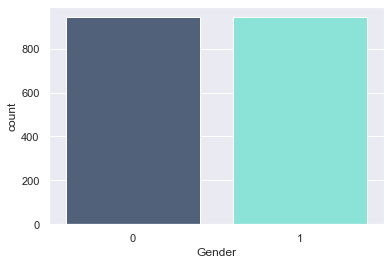

In [22]:
sns.countplot(df.Gender, palette=['#4b5f81',"#7df0e0"]);

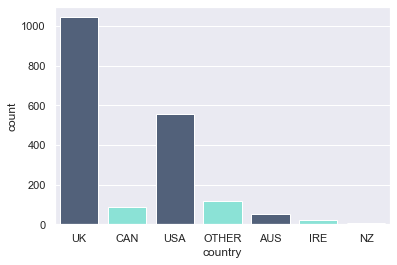

In [23]:
sns.countplot(df['country'], palette=['#4b5f81',"#7df0e0"]);

The frequency plot of *country* shows, that the majority of the participants comes from the UK and USA. In her study, Fehrman (2017)states that the snowball sampling methodology lead to a recruitment of primarily (93.5%) native English-speaking people, with participants from the UK (1044; 55.4%), the USA (557; 29.5%), Canada (87; 4.6%), Australia (54; 2.9%), New Zealand (5; 0.3%) and Ireland (n = 20; 1.1%). 

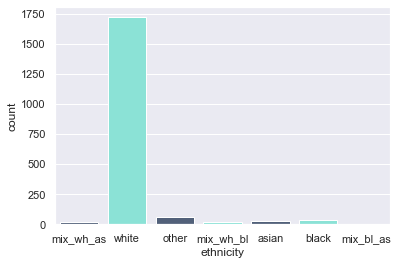

In [24]:
sns.countplot(df['ethnicity'], palette=['#4b5f81',"#7df0e0"]);

An overwhelming majority (91.2%; 1720) reported being White, 1.8% (33) stated they were Black, and 1.4% (26) Asian. The remainder of the sample (5.6%; 106) described themselves as ‘Other’ or ‘Mixed’ categories. Since the majority of the participants were of white ethnicity, the generalizability of the study across other ethnicities is quenstionned. 

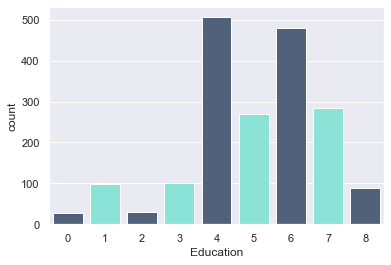

In [25]:
sns.countplot(df['Education'], palette=['#4b5f81',"#7df0e0"]);

The sample recruited was highly educated, with just under two thirds (59.5%) educated to, at a minimum, degree or professional certificate level: 14.4% (271) reported holding a professional certificate or diploma, 25.5% (n = 481) an undergraduate degree, 15% (n = 284) a master’s degree, and 4.7% (n = 89) a doctorate. Approximately 26.8% (n = 506) of the sample had received some college or university tuition although they did not hold any certificates; lastly, 257 (13.6%) had left school at the age of 18 or younger.

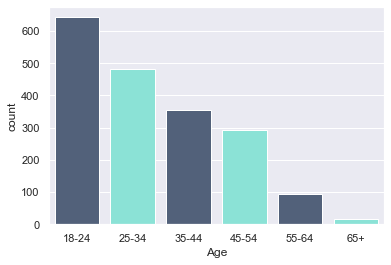

In [26]:
chart = sns.countplot(df['Age'], palette=['#4b5f81',"#7df0e0"]);
chart.set_xticklabels(['18-24','25-34','35-44','45-54','55-64','65+']);

Age has been given in bands: 18-24 years (643; 34.1%), 25-34 years (481; 25.5%), 35-44 years (356; 18.9%), 45-54 years (294; 15.6%), 55-64 (93; 4.9%), and over 65 (18; 1%). This indicates that although the largest age cohort band were in the 18 to 24 range, some 40% of the cohort was 35 or above.

## Drug Usage

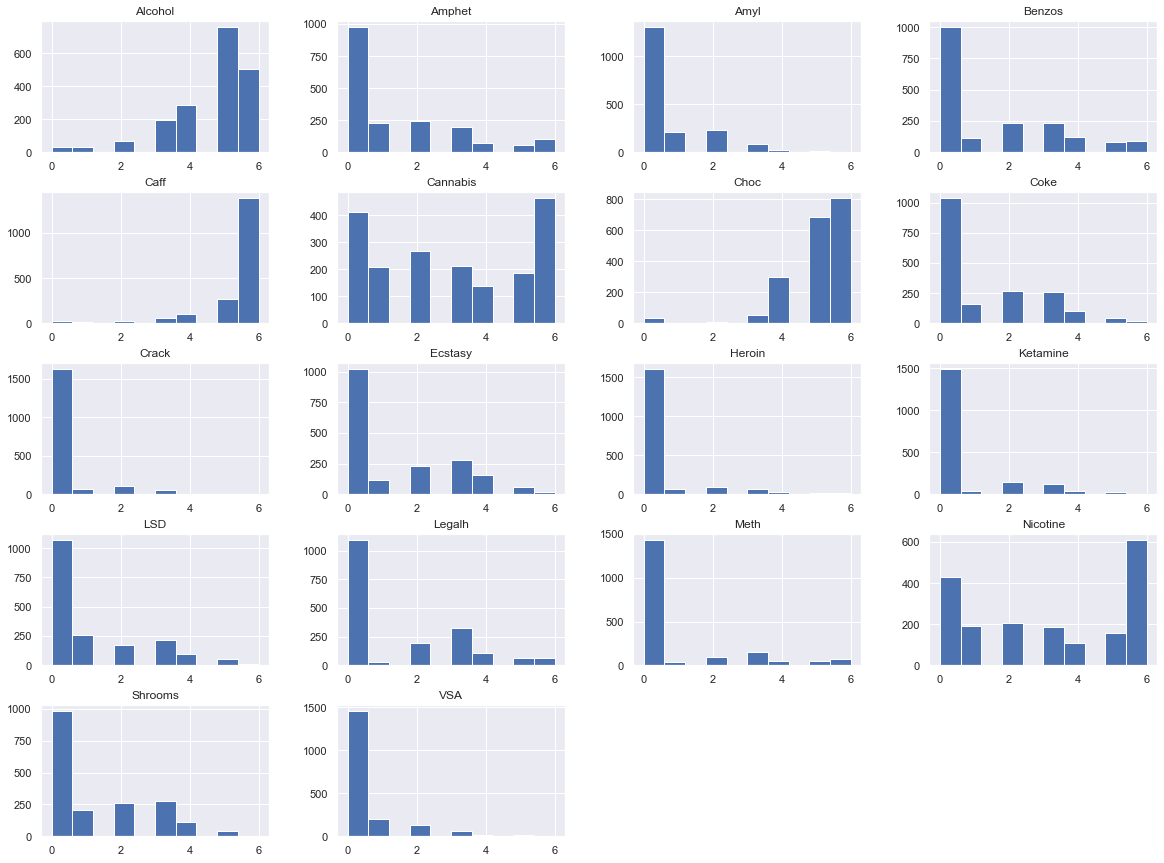

In [27]:
df[drugs].hist(figsize=(20, 15));

## Psychological Measures

*Histogram of features based on the NEO-FFI-R and the Barratt Impulsiveness Scale*

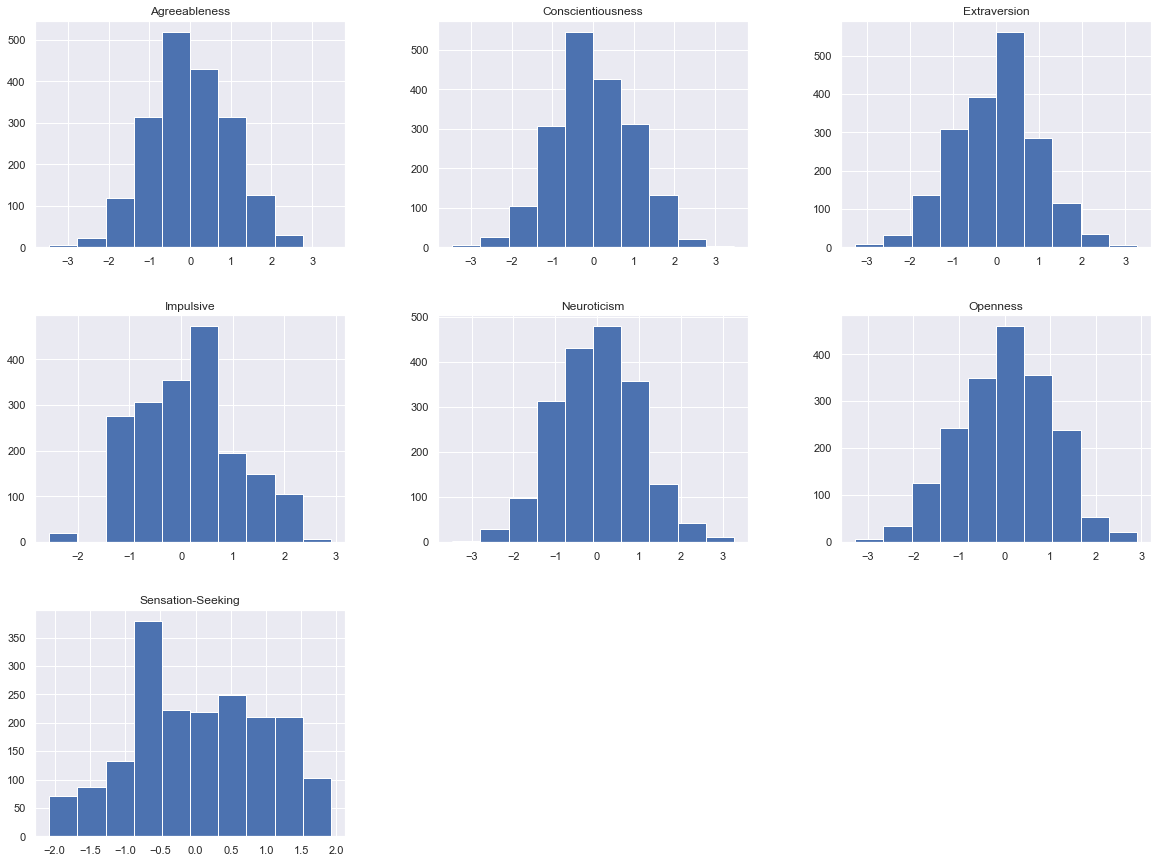

In [28]:
scores = ['Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsive', 'Sensation-Seeking']
df[scores].hist(figsize=(20, 15));

As we can see, the features associated to the NEO-FFI-R and the Barratt Impulsiveness Scale are normally distributed and scaled between -3 and +3. 

# Label Engineering

## Binary classification of the label 'drug use'

The categories ‘Used in last decade’ (CL2), ‘Used over a decade ago’(CL1) and ‘Never used’ (CL0) are merged to form a group of non-users (0) and all other categories are placed into the group of users (1). This classification problem is called ‘year-based’. This classification problem is called *‘year-based’* (Elaine Fehrman et al., 2017). Here, we first replace all 0, 1, and 2 in the drug columns into 'non-users' and the remaining counts in 'user'. 

In [29]:
#replace all values with the corresponding category 

dict = {0 : 0, 1 : 0, 2 : 0, 3 : 1, 4 : 1, 5 : 1, 6 : 1} 

for d in drugs:
    df[d] = df[d].map(dict) 

In [30]:
df.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsive,Sensation-Seeking,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Shrooms,Nicotine,VSA,country,ethnicity
0,2,1,5,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as
1,1,1,7,0.96082,0.126,3.27393,-1.50796,-0.31776,0.59042,-0.65253,-1.37983,0.40148,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as
2,0,0,6,0.96082,0.126,-0.34799,1.28610,-1.11902,0.59042,-0.52745,0.52975,0.07987,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as
3,2,1,6,0.96082,0.126,-1.05308,0.80523,-0.71727,1.28610,0.93949,-0.21712,-0.84637,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as
4,4,1,6,0.96082,0.126,-0.24649,0.96248,0.14143,-0.15487,0.41594,-1.37983,-2.07848,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as


## Frequencyplot of each drug group

In [31]:
lst_plot = drugs.copy()
lst_plot.append('Age')

In [32]:
df_plot = df[['Age','Cannabis']].copy()
df_plot1 = df_plot[df_plot['Cannabis'] == 1].groupby('Age').count()
df_plot1.rename(columns={'Cannabis':'user'}, inplace=True) 
df_plot0 = df_plot[df_plot['Cannabis'] == 0].groupby('Age').count()
df_plot0.rename(columns={'Cannabis':'non_user'}, inplace=True) 

In [33]:
df_plt = pd.merge(df_plot0, df_plot1, left_on='Age', right_on='Age')
print(df_plt)

     non_user  user
Age                
0         107   536
1         243   238
2         233   123
3         219    75
4          67    26
5          17     1


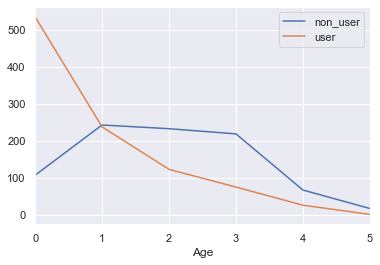

In [34]:
df_plt.plot();

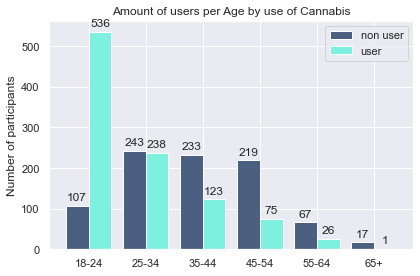

In [35]:
labels = df_plt.index
non_user = df_plt.non_user
user = df_plt.user

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_user, width, label='non user', color='#4b5f81')
rects2 = ax.bar(x + width/2, user, width, label='user', color='#7df0e0')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of participants')
ax.set_title('Amount of users per Age by use of Cannabis')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
ax.set_xticklabels(['18-24','25-34','35-44','45-54','55-64','65+'])
plt.show()


## Distribution of age per score

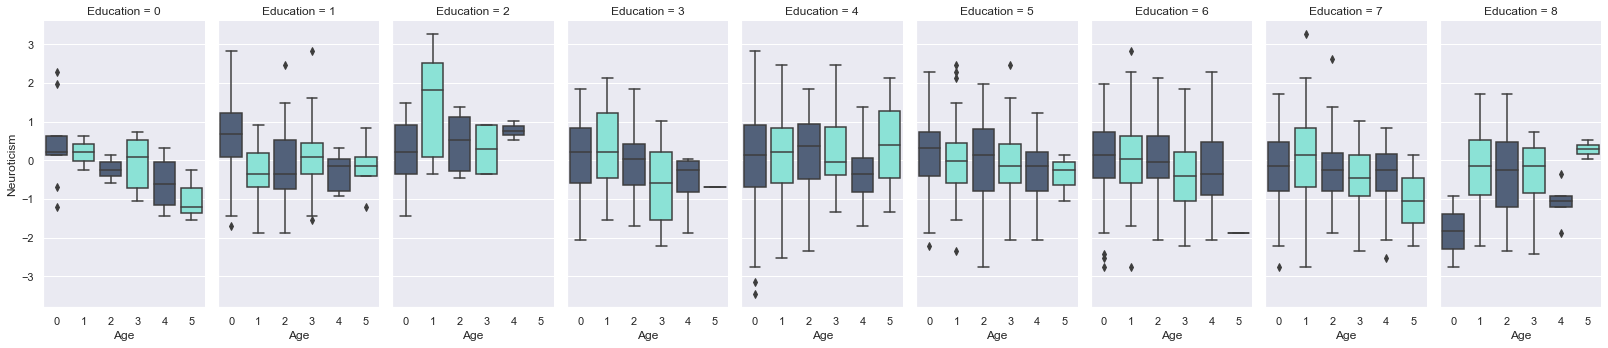

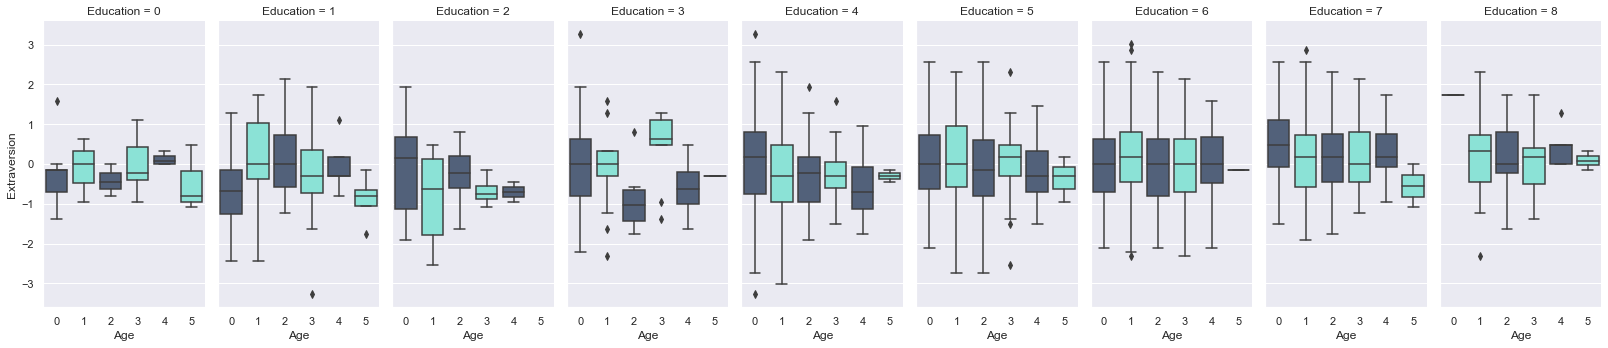

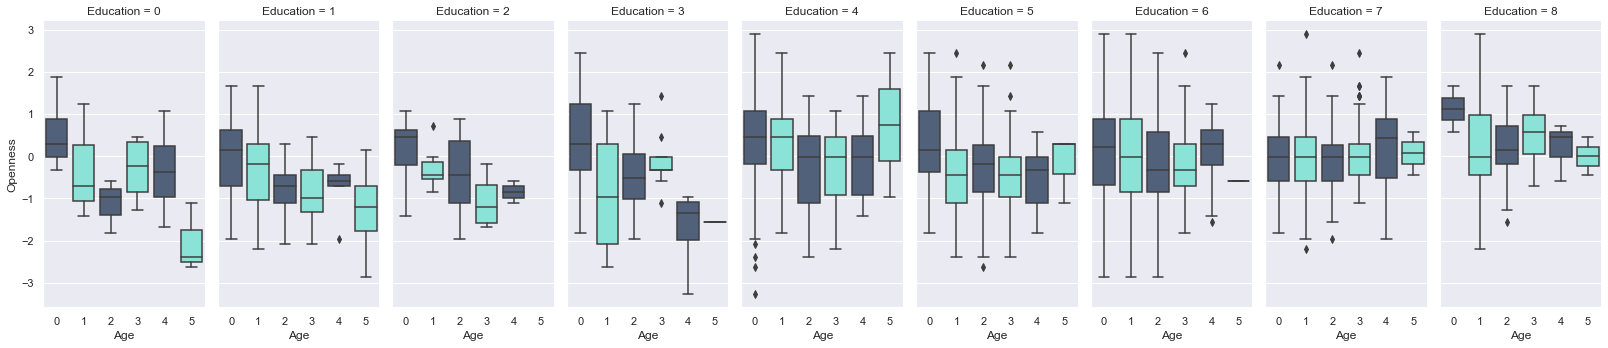

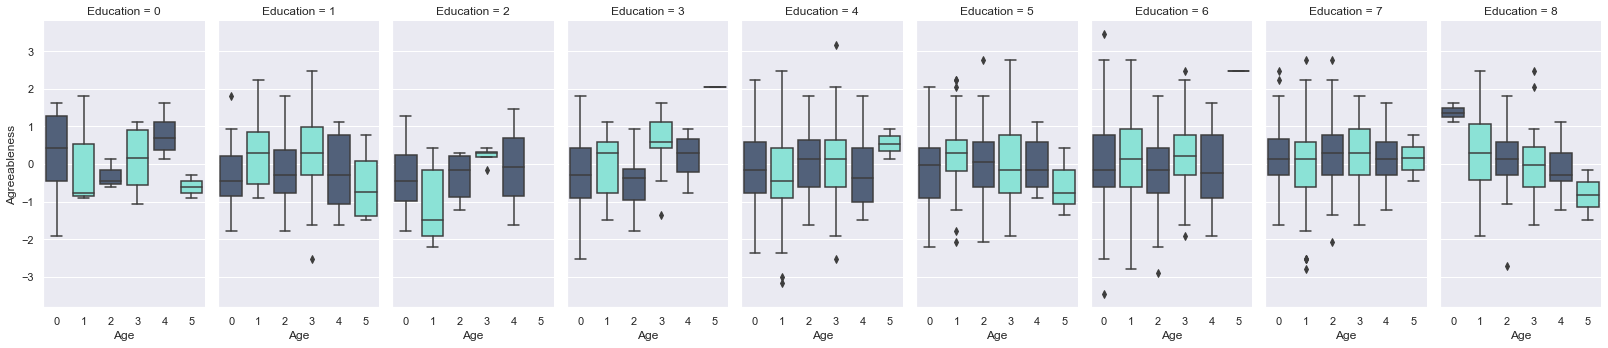

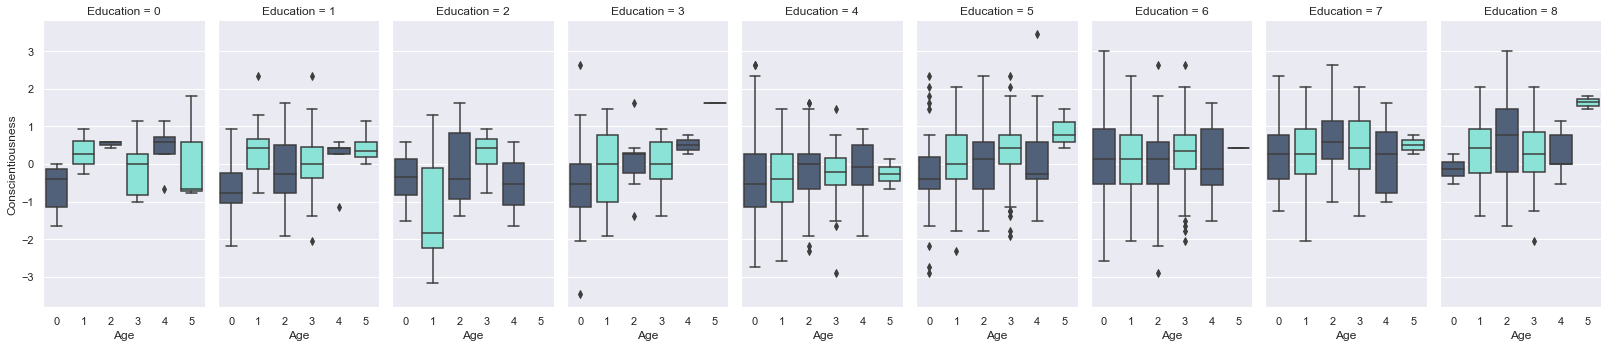

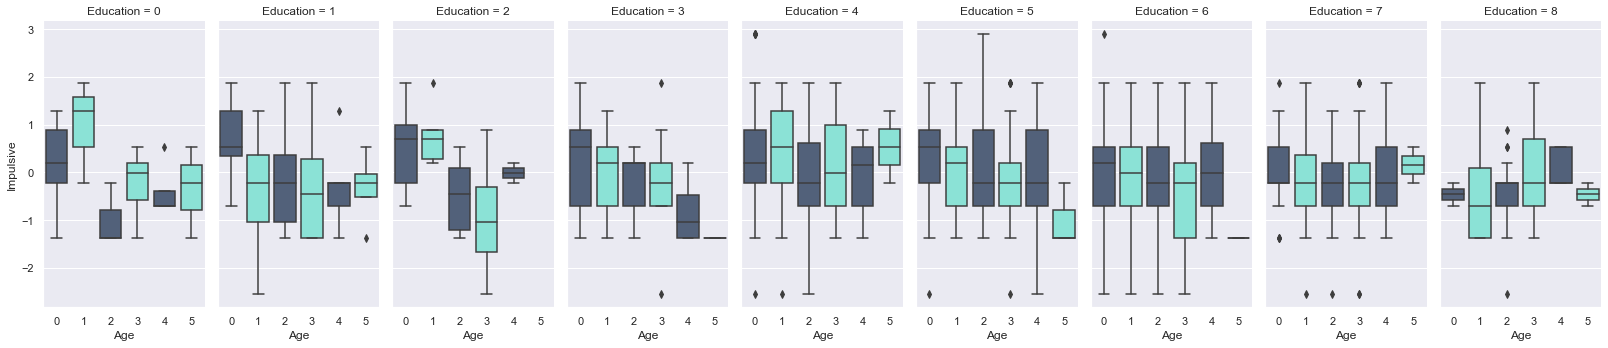

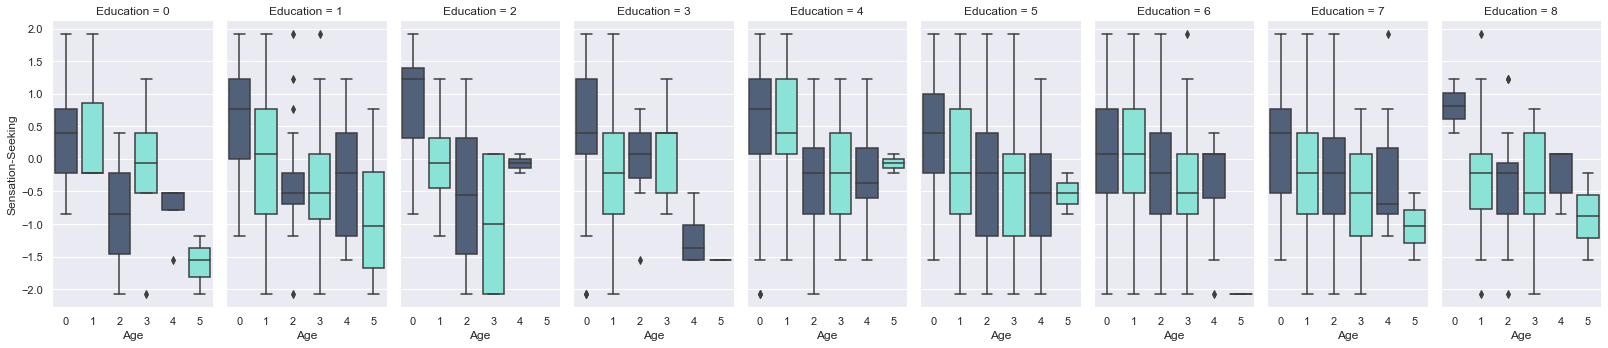

In [55]:
for s in scores:
    g = sns.catplot(x="Age", 
                y=s,
                col='Education', 
                aspect=0.5,
                dodge=False,
                kind="box",
                data=df,
                palette=['#4b5f81',"#7df0e0"]);
    print(g);

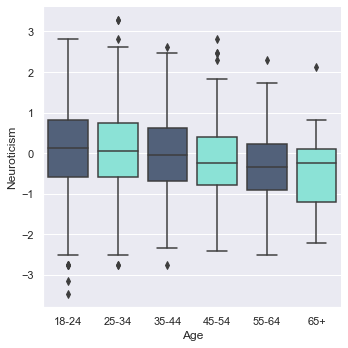

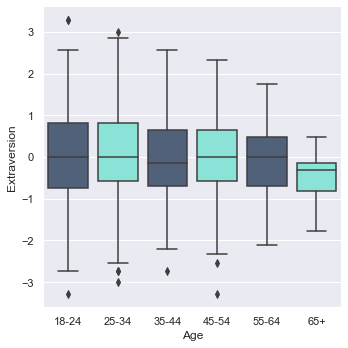

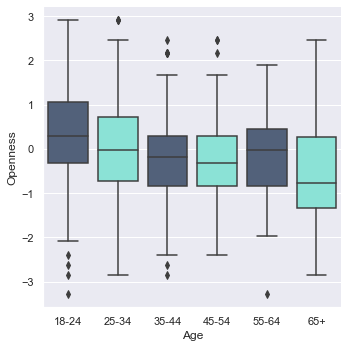

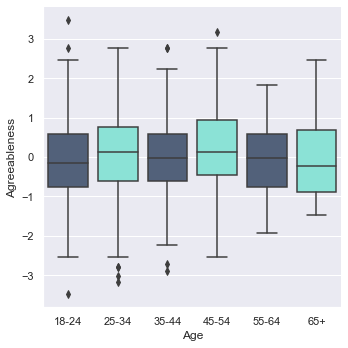

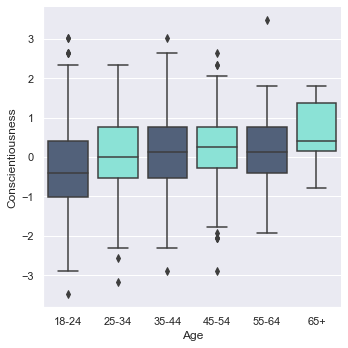

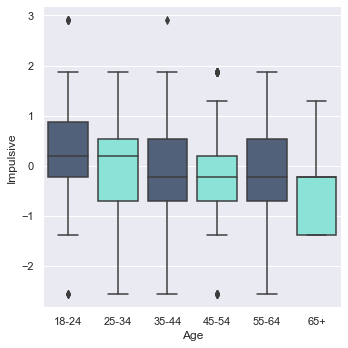

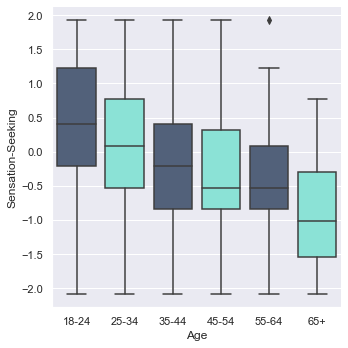

In [37]:
for s in scores:
    chart = sns.catplot(x="Age", y=s, kind="box", data=df, palette=['#4b5f81',"#7df0e0"])
    chart.set_xticklabels(['18-24','25-34','35-44','45-54','55-64','65+'])
    chart.savefig(f"images/boxplot_age_{s}.png")
    print(chart)

# Correlation Plot

After looking at a heatmap of all features, we deleted the ones with no correlation for a better view.

In [38]:
df.columns

Index(['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism',
       'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness',
       'Impulsive', 'Sensation-Seeking', 'Alcohol', 'Amphet', 'Amyl', 'Benzos',
       'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin',
       'Ketamine', 'Legalh', 'LSD', 'Meth', 'Shrooms', 'Nicotine', 'VSA',
       'country', 'ethnicity'],
      dtype='object')

(0.0, 25.0)

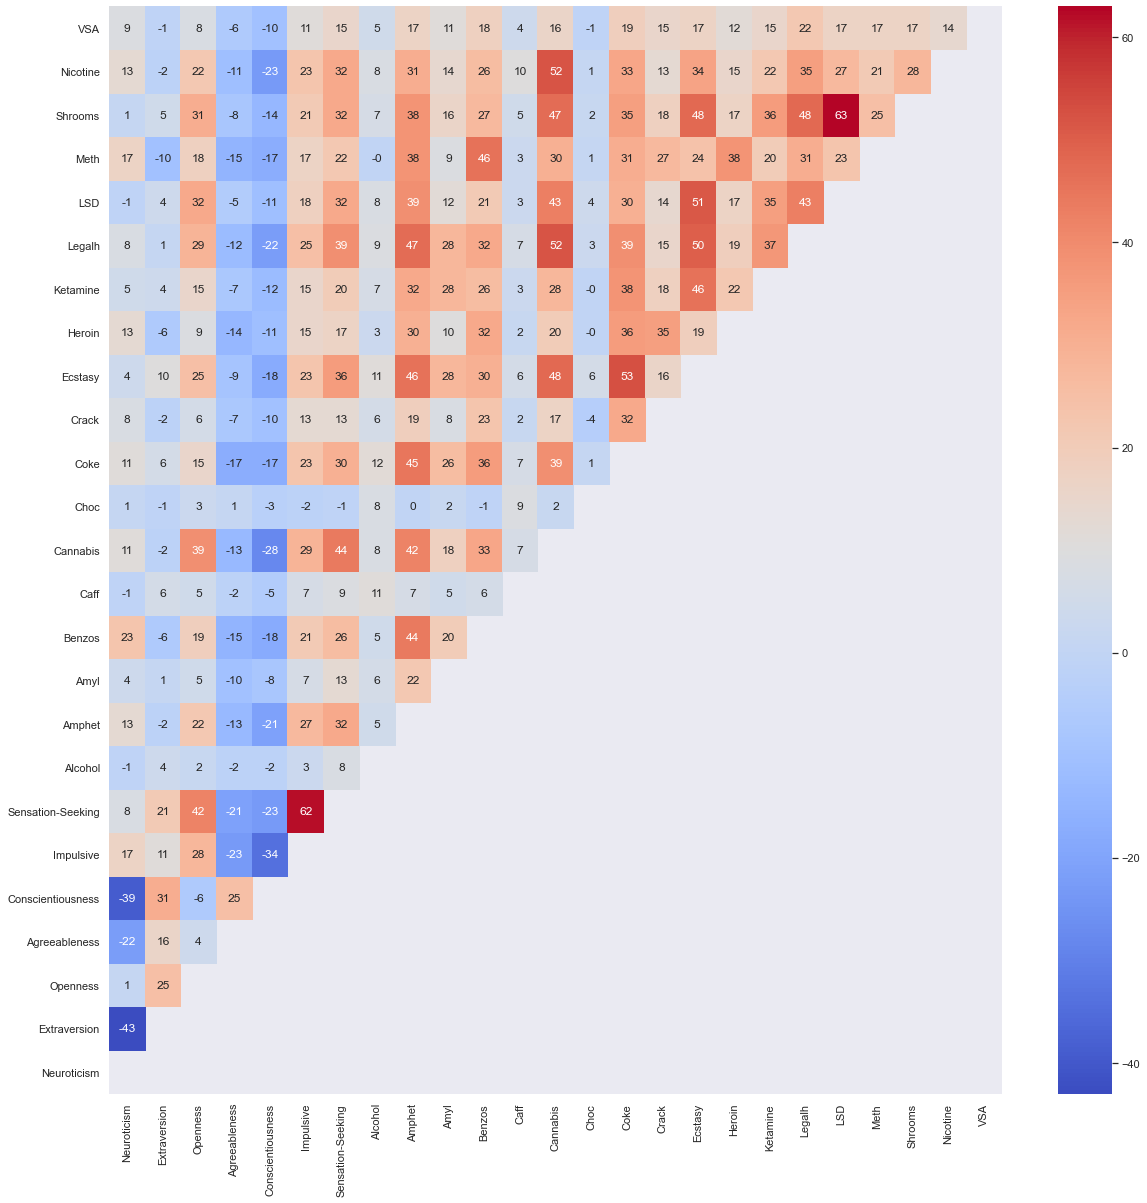

In [39]:
cont_var = ['Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 
            'Conscientiousness', 'Impulsive', 'Sensation-Seeking']
cat_var=['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc',
       'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD',
       'Meth', 'Shrooms', 'Nicotine', 'VSA']
#cont_var

fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
X_dum = pd.get_dummies(df[cont_var+cat_var].copy(), drop_first=True)
#X_dum.head()
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')
ax.set_ylim((0,25))
#plt.savefig(‘figures/correlogram.png’)

# Shuffle and Split Data

We will now split the data (both features and their labels) into training and test sets. 70% of the data will be used for training and 30% for testing.

In [40]:
features = ['Age', 'Gender', 'Education', 'Neuroticism', 'Extraversion', 'Openness',
            'Agreeableness', 'Conscientiousness', 'Impulsive', 'Sensation-Seeking']
label = ['Cannabis']

In [41]:
X = df[features]
y = df[label]

In [42]:
#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1319 samples.
Testing set has 566 samples.


# Prediction of Cannabis Use based on Personality Traits

## Label: Cannabis Use

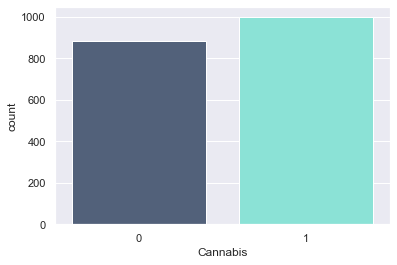

In [43]:
sns.countplot(df['Cannabis'], palette=['#4b5f81',"#7df0e0"]);

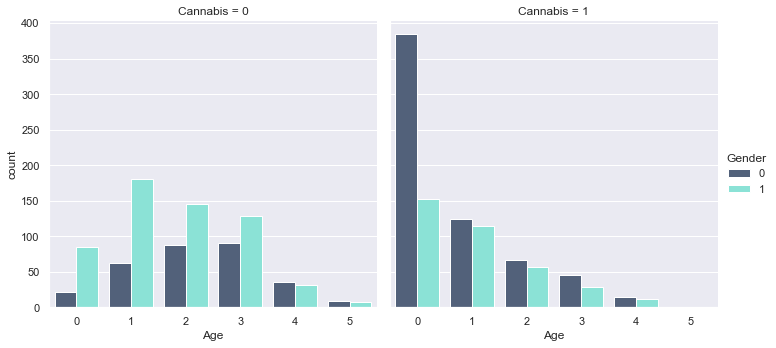

In [99]:
sns.catplot('Age', col='Cannabis', data=df, hue='Gender', 
            kind='count', col_wrap=2, palette=['#4b5f81',"#7df0e0"]);

## Model Selection

Let's train and test the models on training sets of different sizes to see how it affects their runtime and predictive performance (both on the test, and training sets).

### KNN

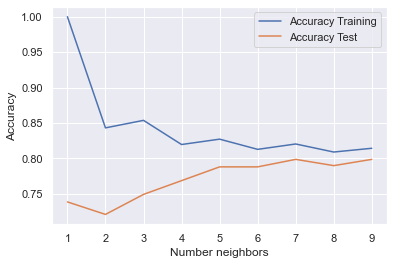

In [45]:
# Correlation Plotsns.catplot('Age', col='Cannabis', data=df, hue='Gender', kind='count', col_wrap=3);
train_accuracy = []
test_accuracy = []

# Probiere Werte für k von 1 bis 10 aus
neighbor_settings = range(1, 10)

for k in neighbor_settings:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbor_settings, train_accuracy, label='Accuracy Training')
plt.plot(neighbor_settings, test_accuracy, label='Accuracy Test')
plt.ylabel('Accuracy')
plt.xlabel('Number neighbors')
plt.legend();

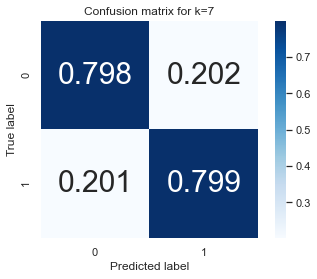

In [46]:
clf_7 = KNeighborsClassifier(n_neighbors=7)
clf_7.fit(X_train, y_train)
#train_accuracy.append(clf.score(X_train, y_train))
#test_accuracy.append(clf.score(X_test, y_test))

cm = confusion_matrix(y_test, clf_7.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for k=7'.format());

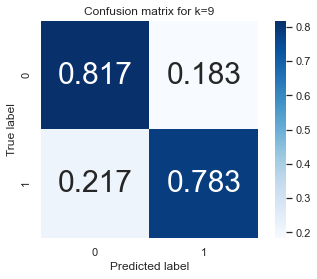

In [47]:
clf_9 = KNeighborsClassifier(n_neighbors=9)
clf_9.fit(X_train, y_train)
#train_accuracy.append(clf.score(X_train, y_train))
#test_accuracy.append(clf.score(X_test, y_test))

cm = confusion_matrix(y_test, clf_9.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for k=9'.format());

In [48]:
print(classification_report(y_test, clf_9.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       257
           1       0.84      0.78      0.81       309

    accuracy                           0.80       566
   macro avg       0.80      0.80      0.80       566
weighted avg       0.80      0.80      0.80       566



### LR, RFC, SVC, XGB

In [49]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
#from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [50]:
# TODO: Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = LogisticRegression(random_state=101)
clf_B = RandomForestClassifier(random_state = 101)
clf_C = SVC(random_state = 101)
clf_D = KNeighborsClassifier(n_neighbors=7)
clf_E = XGBClassifier(random_state=101)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 13 samples.
LogisticRegression trained on 132 samples.
LogisticRegression trained on 1319 samples.
RandomForestClassifier trained on 13 samples.
RandomForestClassifier trained on 132 samples.
RandomForestClassifier trained on 1319 samples.
SVC trained on 13 samples.
SVC trained on 132 samples.
SVC trained on 1319 samples.
KNeighborsClassifier trained on 13 samples.
KNeighborsClassifier trained on 132 samples.
KNeighborsClassifier trained on 1319 samples.
XGBClassifier trained on 13 samples.
XGBClassifier trained on 132 samples.
XGBClassifier trained on 1319 samples.


## Model Evaluation

### Classification Report

In [51]:
for x in [clf_A, clf_B, clf_C, clf_D]:
    print('Classification Report for {}'.format(x))
    print(classification_report(y_test, x.predict(X_test)))
    print('\n\n')

Classification Report for LogisticRegression(random_state=101)
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       257
           1       0.82      0.78      0.80       309

    accuracy                           0.79       566
   macro avg       0.78      0.79      0.79       566
weighted avg       0.79      0.79      0.79       566




Classification Report for RandomForestClassifier(random_state=101)
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       257
           1       0.84      0.79      0.81       309

    accuracy                           0.80       566
   macro avg       0.80      0.81      0.80       566
weighted avg       0.81      0.80      0.80       566




Classification Report for SVC(random_state=101)
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       257
           1       0.83      0.78      0.80       309

### Time, Accuracy, F-Beta

In [52]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
acc_test,0.699647,0.757951,0.786219
acc_train,0.676667,0.823333,0.773333
f_test,0.708491,0.786249,0.810449
f_train,0.691658,0.836386,0.791411
pred_time,0.002778,0.002700,0.002346
train_time,0.007347,0.006498,0.008764


RandomForestClassifier


,1%,10%,100%
acc_test,0.683746,0.779152,0.803887
acc_train,0.646667,0.850000,1.000000
f_test,0.691037,0.799087,0.831622
f_train,0.664100,0.870394,1.000000
pred_time,0.026378,0.024625,0.026520
train_time,0.085824,0.094442,0.157016


SVC


,1%,10%,100%
acc_test,0.545936,0.765018,0.793286
acc_train,0.546667,0.806667,0.800000
f_test,0.600466,0.791246,0.821355
f_train,0.599706,0.822086,0.819775
pred_time,0.003242,0.004150,0.012742
train_time,0.002195,0.002416,0.029234


KNeighborsClassifier


,1%,10%,100%
acc_test,0.584806,0.742049,0.798587
acc_train,0.586667,0.740000,0.793333
f_test,0.621720,0.762332,0.820598
f_train,0.621663,0.758123,0.817369
pred_time,0.027042,0.024986,0.034520
train_time,0.002622,0.002901,0.003224


XGBClassifier


,1%,10%,100%
acc_test,0.591873,0.752650,0.784452
acc_train,0.620000,0.840000,0.870000
f_test,0.625832,0.775805,0.817544
f_train,0.642434,0.857322,0.884184
pred_time,0.001890,0.003428,0.003588
train_time,0.006685,0.015776,0.078745


### Confusion Matrix 

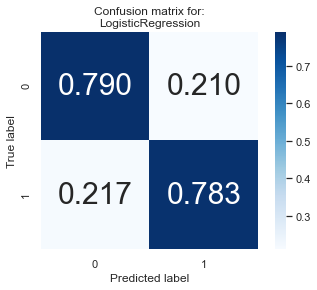

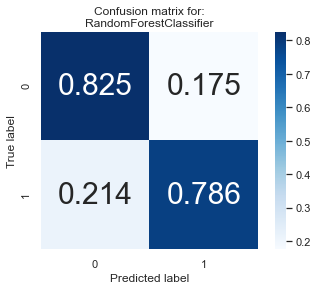

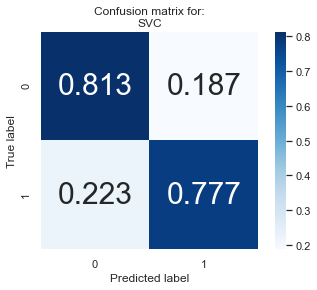

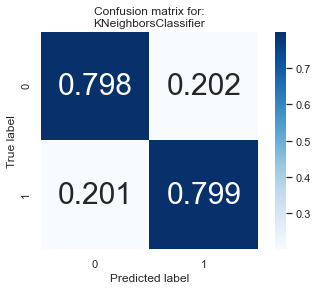

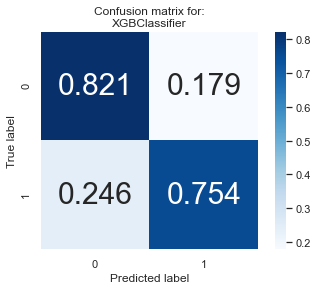

In [53]:
for i,model in enumerate([clf_A,clf_B,clf_C, clf_D, clf_E]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

### ROC Curve & AUC Score

The receiver operating characteristic (ROC) curve plots the **true positive rate** (another name for recall) against the **false positive rate** (FPR). 
 
The FPR is the ratio of negative instances that are incorrectly classified as positive. Thus, a classified high risk of drug usage where there is truly only a low risk. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. Thus, a correclty classified low risk of drug usage. The TNR is also called specificity, meaning, how correctly the model predicts low risk of drug usage. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

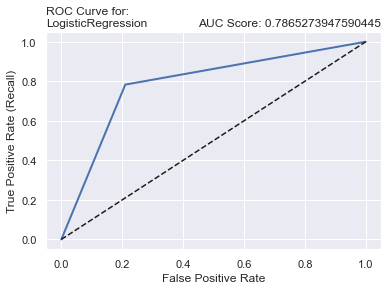

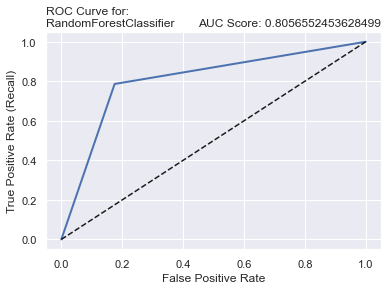

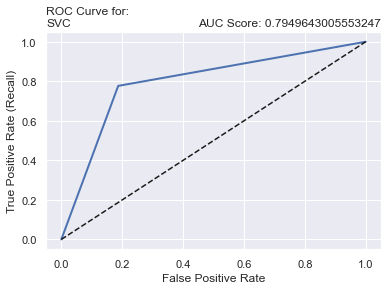

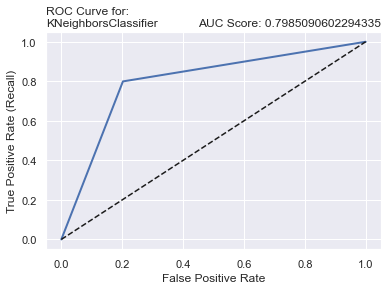

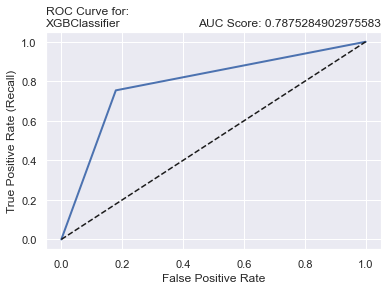

In [54]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

for i,model in enumerate([clf_A,clf_B,clf_C, clf_D, clf_E]):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
    auc_score = roc_auc_score(y_test, model.predict(X_test))
    
    plt.figure(i)
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve for:\n{}'.format(model.__class__.__name__), loc='left');
    plt.title(f'AUC Score: {auc_score}', loc='right')

## GridSearch

Scikit-Learn’s GridSearchCV uses use cross-validation to evaluate all the possible combinations of hyperparameter values. We apply GridSearch to all five models that we have looked at so far. 

### Preprocessing

#### Settings

In [43]:
# Selecting Data
X = df[features]
y = df['Cannabis']

d = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [44]:
my_scorer = make_scorer(f1_score, average='weighted')
c = KFold(3, random_state=42)

In [45]:
# Creating grids for the models
grid_lr = {'C': list(range(1, 100)),
             'penalty':['l1', 'l2'], 
             'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
             }

grid_rf = {'n_estimators' : list(range(1,30)),
             'max_depth': [5, 8, 15, 25, 30],
             'max_features' : ['auto', 'sqrt'],
             'min_samples_split' : [2, 5, 10]}
grid_svm = {'C': [1, 5, 10, 50],
             'kernel': ['linear', 'rbf', 'poly']
             }
grid_xgb = {'max_depth': list(range(1,5)),
             'min_child_weight': list(range(0,15)),
             'subsample': [0.01, 0.1, 0.5, 1]
             }
grid_knn = {'n_neighbors' : list(range(1,50)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,50))
             }

In [46]:
# Creating list of models for the function below
try_models = [['LogReg', LogisticRegression(random_state=42), grid_lr, c, my_scorer, d],
             ['RandomForest', RandomForestClassifier(random_state=42), grid_rf, c, my_scorer, d],
             ['SVM', SVC(random_state=42), grid_svm, c, my_scorer, d],
             ['XGBoost', XGBClassifier(random_state=42), grid_xgb, c, my_scorer, d],
             ['KNN', KNeighborsClassifier(), grid_knn, c, my_scorer, d]]

#### Functions

In [47]:
def modelling(clf, grid, cv, score, data):
    """
        clf: Instance of the modell
        grid: parameter grid
        cv: crossvalidation
        score: scoring parameter
        data: data to use as list(train/test-split)
        
        Returns a dictionary with the scorings and best parameter
    """
    X_train, X_test, y_train, y_test = data
    
    grid_model = GridSearchCV(clf, param_grid=grid, 
                        cv=cv, 
                        verbose=False, n_jobs=-1,
                        scoring=score)
    best_model = grid_model.fit(X_train, y_train)
    #model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    scores = {'test':{},
             'train': {}}
    scores['Best_Parameter'] = best_model.best_params_
    scores['test'] = {'F1_score': f1_score(y_test, y_pred),
                      'Accuracy': accuracy_score(y_test, y_pred),
                      'Precision': precision_score(y_test, y_pred),
                      'Recall': recall_score(y_test, y_pred),
                      'AUC': roc_auc_score(y_test, y_pred)}
    return scores

In [48]:
def get_test_results(model_list):
    """
        Needs a list of models with a list of parameters for each modeL:
        - Name of Model
        - Instance of the Model,
        - Grid
        - crossvalidation,
        - scoring parameter
        - data
    """
    start = time()
    results = {m[0]:modelling(*m[1:]) for m in model_list}
    test_result = {k:v['test'] for k, v in results.items()}
    for k, v in results.items():
        test_result[k]['Best_Parameter'] = v['Best_Parameter']
    df_test = pd.DataFrame(test_result).T
    df = df_test[['F1_score', 'Accuracy', 'Precision', 'Recall', 'AUC', 'Best_Parameter']]
    print(f'Runtime: ist {(time()-start):.1f} seconds')
    return df

#### Check Results

In [61]:
df_cannabis = get_test_results(try_models)

Runtime: ist 112.4 seconds


In [62]:
df_cannabis.sort_values('F1_score', ascending=False)

,F1_score,Accuracy,Precision,Recall,AUC,Best_Parameter
XGBoost,0.81457,0.80212,0.833898,0.796117,0.802728,"{'max_depth': 2, 'min_child_weight': 13, 'subs..."
SVM,0.80402,0.793286,0.833333,0.776699,0.794964,"{'C': 1, 'kernel': 'rbf'}"
LogReg,0.8,0.786219,0.817568,0.783172,0.786527,"{'C': 2, 'penalty': 'l1', 'solver': 'saga'}"
RandomForest,0.792013,0.779152,0.815068,0.770227,0.780055,"{'max_depth': 5, 'max_features': 'auto', 'min_..."
KNN,0.788396,0.780919,0.833935,0.747573,0.784292,"{'leaf_size': 1, 'n_neighbors': 49, 'weights':..."


### KNN

In [63]:
X_train, X_test, y_train, y_test = d

knn_model = KNeighborsClassifier(leaf_size= 1, n_neighbors=49, weights='distance')
knn = knn_model.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f'Optimized F1 Score: {f1_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')

Optimized F1 Score: 78.84
Optimized Accuracy: 78.09
Optimized Precision: 83.39
Optimized Recall: 74.76


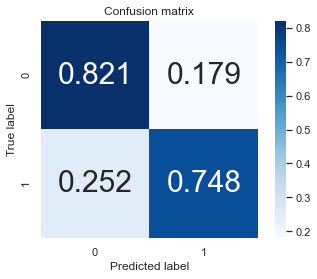

In [64]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.82      0.77       257
           1       0.83      0.75      0.79       309

    accuracy                           0.78       566
   macro avg       0.78      0.78      0.78       566
weighted avg       0.79      0.78      0.78       566



**Optimization KNN Model**: 
 
We obtain the best solution by setting the *leaf_size hyperparameter* to 1, the *n_neighbors hyperparameter* to 49 und *weights hyperparameter* to 'distance'. The **F1 score** for this combination is 0.7863 and the **Accuracy** is 0.7809, which is slightly worse than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** decreased for the 'Non-User'- group and stayed the same for the 'User' - group. **Recall** increased for the 'Non-User'- group and decreased for the 'User' - group. 

### LR

In [66]:
X_train, X_test, y_train, y_test = d

logreg_model = LogisticRegression(C=2, penalty='l1', solver='saga')
lr = logreg_model.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f'Optimized F1 Score: {f1_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')

Optimized F1 Score: 80.00
Optimized Accuracy: 78.62
Optimized Precision: 81.76
Optimized Recall: 78.32


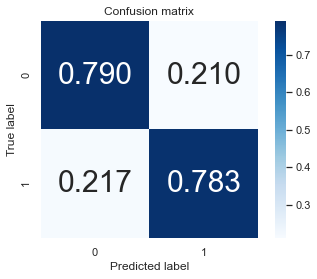

In [67]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       257
           1       0.82      0.78      0.80       309

    accuracy                           0.79       566
   macro avg       0.78      0.79      0.79       566
weighted avg       0.79      0.79      0.79       566



**Optimization LR Model**: 
 
We obtain the best solution by setting the *C hyperparameter* to 77, the *penalty hyperparameter* to l2 und *solver hyperparameter* to 'sag'. The **F1 score** for this combination is 0.7907 and the **Accuracy** is 0.7862, which is slightly worse/better than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** and **recall** did not change for any of the groups. 

### Random Forest

In [69]:
X_train, X_test, y_train, y_test = d

rf_model = RandomForestClassifier(max_depth=5, max_features='auto', min_samples_split=5, 
                                  n_estimators=10)
rf = rf_model.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f'Optimized F1 Score: {f1_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')

Optimized F1 Score: 78.01
Optimized Accuracy: 77.39
Optimized Precision: 83.15
Optimized Recall: 73.46


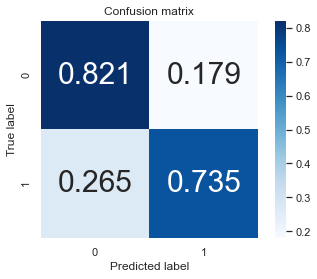

In [70]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77       257
           1       0.83      0.73      0.78       309

    accuracy                           0.77       566
   macro avg       0.78      0.78      0.77       566
weighted avg       0.78      0.77      0.77       566



**Optimization Random Forest Model**: 
 
We obtain the best solution by setting the *max_depth hyperparameter* to 5, the *max_features hyperparameter* to 'sqrt' und *n_estimators hyperparameter* to 16. The **F1 score** for this combination is 0.7903 and the **Accuracy** is 0.8021, which is slightly worse than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** slightly increased for the 'User'- group and **recall** slightly increased for both groups. 

#### Feature Importance

An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual has an increased risk for drug usage or not. 

In [72]:
feature_importances = rf.feature_importances_
sorted(zip(feature_importances, features), reverse=True)

[(0.30100461588868005, 'Age'),
 (0.16535237920106155, 'Openness'),
 (0.1494264449413057, 'Sensation-Seeking'),
 (0.11040077025921322, 'Education'),
 (0.07953939971259924, 'Gender'),
 (0.06953183053453686, 'Conscientiousness'),
 (0.04546531950591841, 'Impulsive'),
 (0.04135704073566941, 'Neuroticism'),
 (0.019180023619703918, 'Extraversion'),
 (0.018742175601311663, 'Agreeableness')]

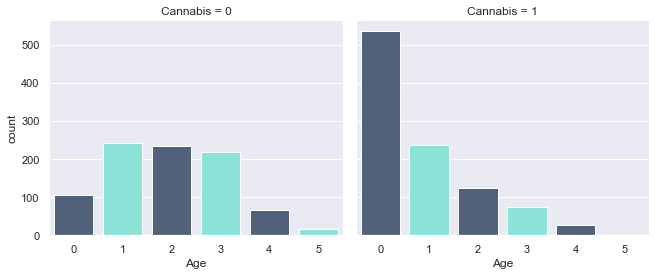

In [73]:
sns.catplot(x="Age", col="Cannabis", col_wrap=4, data=df, kind="count", 
            height=4, aspect=1.1, palette=['#4b5f81',"#7df0e0"]);

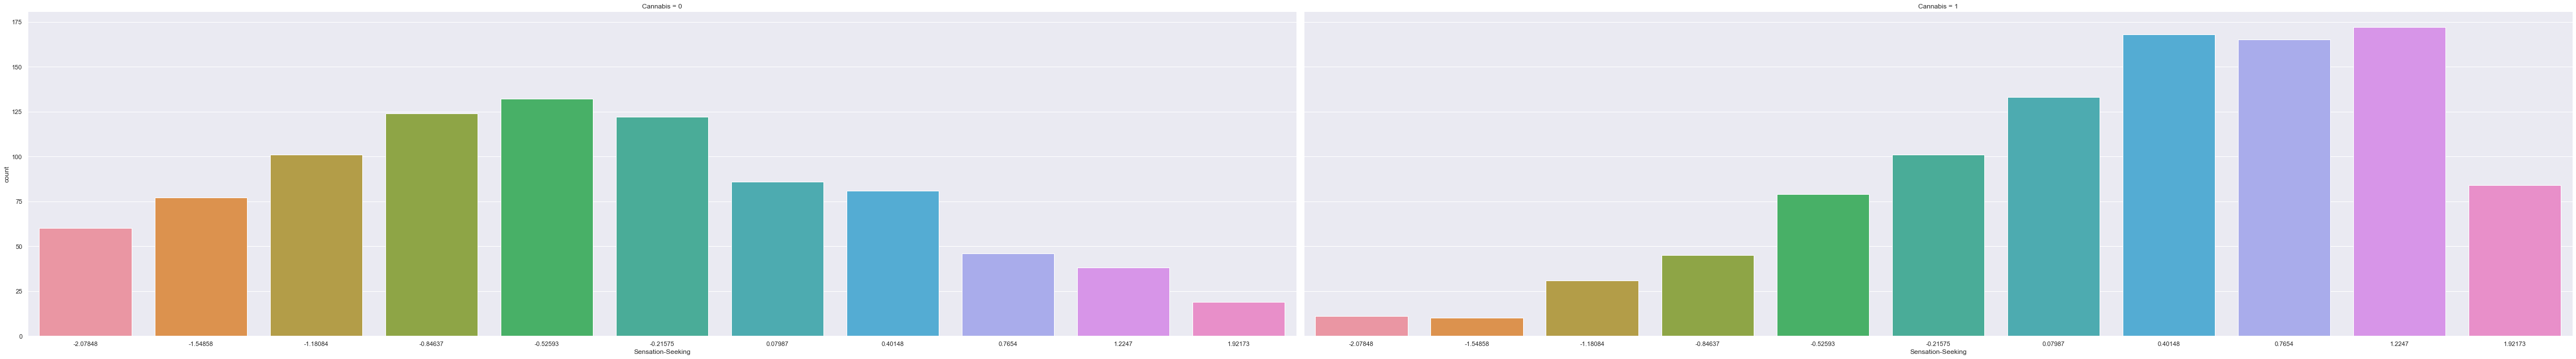

In [74]:
sns.catplot(x="Sensation-Seeking", col="Cannabis", col_wrap=4, data=df, kind="count", height=9, aspect=3.5);

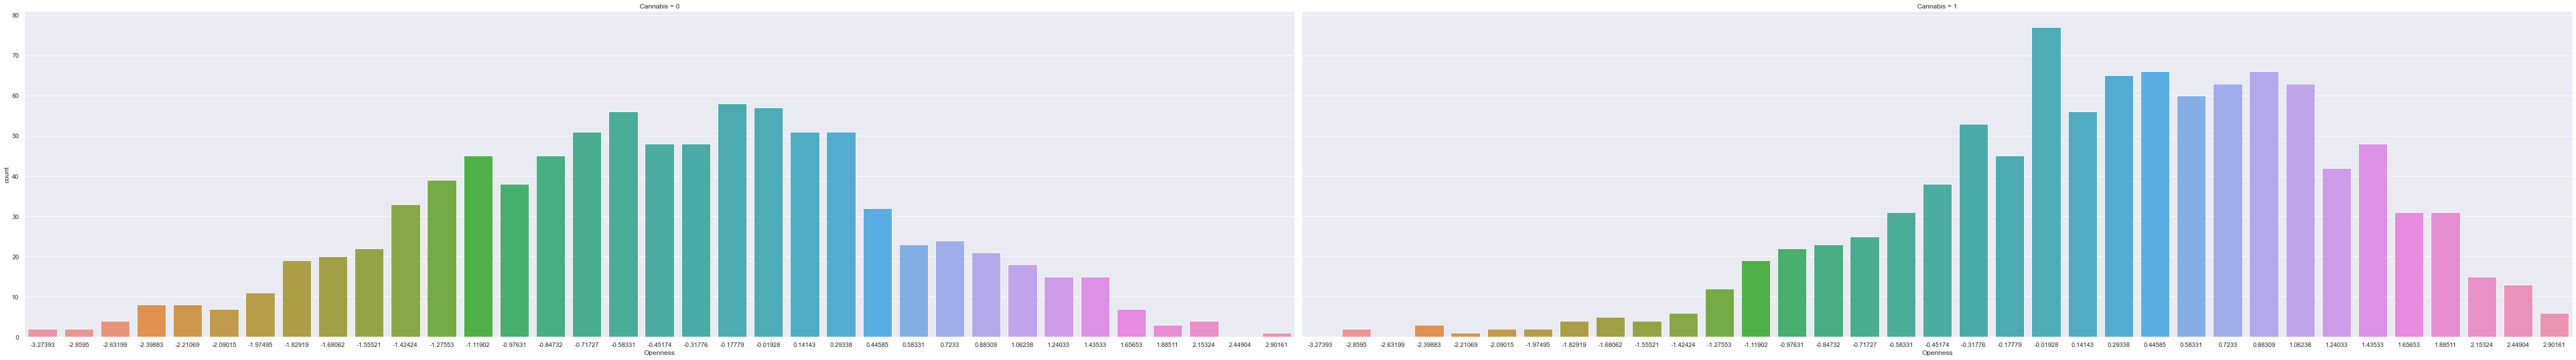

In [75]:
sns.catplot(x="Openness", col="Cannabis", col_wrap=4, data=df, kind="count", height=9, aspect=3.5);

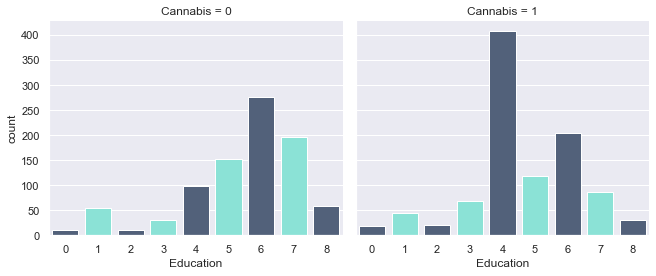

In [101]:
sns.catplot(x="Education", col="Cannabis", col_wrap=4, data=df, 
            kind="count", height=4, aspect=1.1, palette=['#4b5f81',"#7df0e0"]);

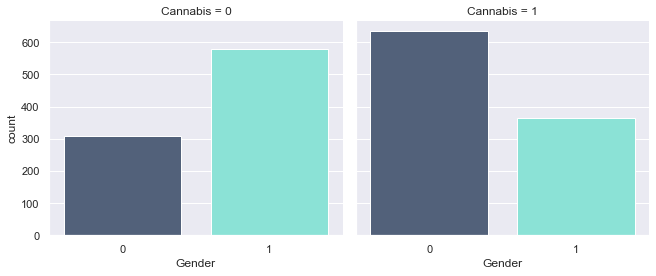

In [77]:
sns.catplot(x="Gender", col="Cannabis", col_wrap=4, data=df, 
            kind="count", height=4, aspect=1.1, palette=['#4b5f81',"#7df0e0"]);

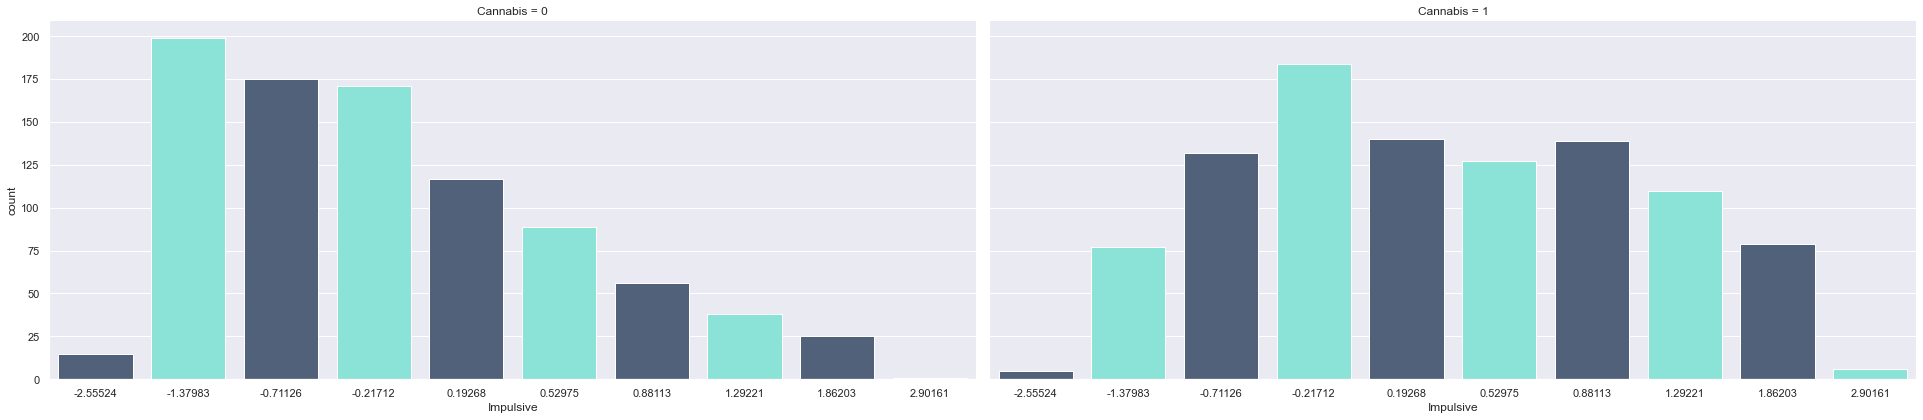

In [102]:
sns.catplot(x="Impulsive", col="Cannabis", col_wrap=4, data=df, 
            kind="count", height=6, aspect=2.2, palette=['#4b5f81',"#7df0e0"]);

### SVC

Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel) to determine the best model. 

In [79]:
X_train, X_test, y_train, y_test = d

svc_model = SVC(C=1, kernel='rbf')
svc = svc_model.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f'Optimized F1 Score: {f1_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')

Optimized F1 Score: 80.40
Optimized Accuracy: 79.33
Optimized Precision: 83.33
Optimized Recall: 77.67


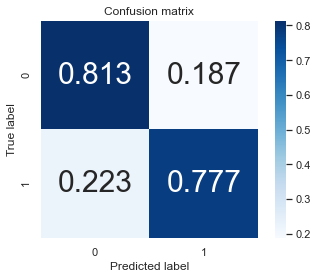

In [80]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       257
           1       0.83      0.78      0.80       309

    accuracy                           0.79       566
   macro avg       0.79      0.79      0.79       566
weighted avg       0.80      0.79      0.79       566



**Optimization SVC Model**: 
 
We obtain the best solution by setting the *C hyperparameter* to 5 and the *kernel hyperparameter* to 'linear'. Unfortunately, we were not able to inspect more hyperparameters due to limited power. The **F1 score** for this combination is 0.7900 and the **Accuracy** is 0.7897, which is slightly worse/better than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** and **recall** remained the same for both groups. 

### XGBoost

*max_depth*: maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.

*min_child_weight*: minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

*subsample*: corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.

In [49]:
X_train, X_test, y_train, y_test = d

xgb_model = XGBClassifier(max_depth=2, min_child_weight=13, subsample=0.5)
xgb = xgb_model.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(f'Optimized F1 Score: {f1_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')

Optimized F1 Score: 81.26
Optimized Accuracy: 80.04
Optimized Precision: 83.33
Optimized Recall: 79.29


In [53]:
xgb_feat = xgb.feature_importances_
sorted(zip(xgb_feat, features), reverse=True)

[(0.23239353, 'Sensation-Seeking'),
 (0.20810224, 'Age'),
 (0.1094444, 'Education'),
 (0.10030535, 'Openness'),
 (0.08634345, 'Gender'),
 (0.072868094, 'Conscientiousness'),
 (0.050018445, 'Extraversion'),
 (0.049331788, 'Agreeableness'),
 (0.04809438, 'Neuroticism'),
 (0.043098215, 'Impulsive')]

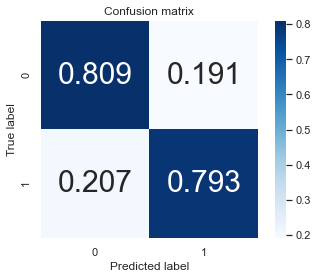

In [83]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79       257
           1       0.83      0.79      0.81       309

    accuracy                           0.80       566
   macro avg       0.80      0.80      0.80       566
weighted avg       0.80      0.80      0.80       566



**Optimization XGBoost Model**: 
 
We obtain the best solution by setting the *max_depth hyperparameter* to 2 and the *min_child_weight hyperparameter* to 10 and *subsample hyperparameter* to 1. The **F1 score** for this combination is 0.7984 and the **Accuracy** is 0.8021, which is slightly worse/better than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** for the non-user group slightly increased and for the user-group remained the same. **Recall** increased for the user-group and remained the same for the non-user group. 

# XGBoost for all drugs

In [85]:
pd.set_option('max_colwidth', 100)
pd.set_option('precision', 4)

In [86]:
# Creating list of labels
labels = drugs.copy()

# set features
X = df[features]

results = {}
for x in labels:
    results[x] = {}
    y = df[x]
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.3, 
                                                        random_state = 42)
    model = XGBClassifier(max_depth=2, min_child_weight=13, subsample=0.5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #print(f'{x} - F1 Score: {f1_score(y_test, y_pred)*100:.2f}')
    #print(f'{x} - Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
    #print(f'{x} - Recall: {recall_score(y_test, y_pred)*100:.2f)} )
    results[x] = {'F1_Score': f1_score(y_test, y_pred),
                'Accuracy':accuracy_score(y_test, y_pred),
                'Recall' :recall_score(y_test, y_pred)}

df_drug_results = pd.DataFrame(results).T

Along with our expections, our XGBoost-Model for Cannabis does not work to predict usage for the other drugs.

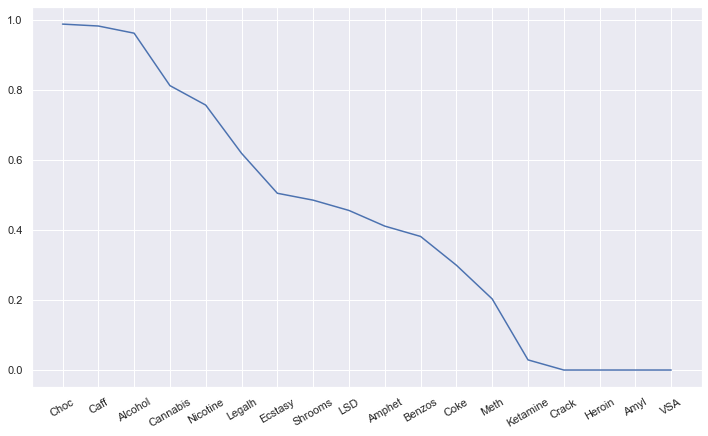

In [87]:
plt.figure(figsize=(12,7))
plt.plot(df_drug_results.sort_values('F1_Score', ascending=False)['F1_Score'])
plt.xticks(rotation=30);

# Prediction of risk of highly addictive drug use

We create a list of drugs that have a high rate of potential abuse along with significant psychological or physical dependence.

In [88]:
print(drugs)

['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Shrooms', 'Nicotine', 'VSA']


In [58]:
# Drugs who are not used in this chapter
to_drop = ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 
 'Choc', 'Crack',  'Ketamine', 
 'Legalh', 'Nicotine', 'Shrooms', 'VSA']

In [59]:
hard1 = ['Heroin', 'Ecstasy', 'LSD', 'Coke', 'Meth']

In [60]:
df_hard1 = df.copy()
df_hard1.drop(columns=to_drop, inplace=True)
df_hard1.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsive,Sensation-Seeking,Coke,Ecstasy,Heroin,LSD,Meth,country,ethnicity
0,2,1,5,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0,0,0,0,0,UK,mix_wh_as
1,1,1,7,0.96082,0.126,3.27393,-1.50796,-0.31776,0.59042,-0.65253,-1.37983,0.40148,0,0,0,0,0,UK,mix_wh_as
2,0,0,6,0.96082,0.126,-0.34799,1.28610,-1.11902,0.59042,-0.52745,0.52975,0.07987,0,0,0,0,0,UK,mix_wh_as
3,2,1,6,0.96082,0.126,-1.05308,0.80523,-0.71727,1.28610,0.93949,-0.21712,-0.84637,0,0,0,0,0,UK,mix_wh_as
4,4,1,6,0.96082,0.126,-0.24649,0.96248,0.14143,-0.15487,0.41594,-1.37983,-2.07848,0,0,0,0,0,UK,mix_wh_as


**Users of highly addictive drugs**

In [61]:
#Building nuew feature for usage of these kind of drugs
df_hard1['hard_use'] = np.where(df_hard1[hard1].sum(axis=1)==0,0,1)

In [93]:
df_hard1.sample(10)

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsive,Sensation-Seeking,Coke,Ecstasy,Heroin,LSD,Meth,country,ethnicity,hard_use
1573,3,0,5,-0.2852,-0.3169,0.4167,0.4762,0.2934,-1.0753,-1.1379,0.8811,0.0799,0,0,0,0,0,OTHER,white,0
31,3,0,1,0.9608,-0.3169,0.5213,-1.2318,-0.3178,-0.4532,-1.3850,-1.3798,-0.8464,0,0,0,0,0,UK,white,0
1117,1,0,4,-0.5701,-0.3169,0.1361,-0.4400,-0.8473,-0.3017,-0.0066,-0.7113,-1.5486,0,0,1,0,1,USA,white,1
1250,0,0,4,-0.5701,-0.3169,0.2239,-0.6951,0.1414,-0.6063,-0.2761,0.1927,0.4015,1,0,0,1,0,USA,white,1
1208,0,1,4,-0.5701,-0.3169,-1.1943,0.3220,1.8851,0.5904,-0.1428,2.9016,1.9217,1,1,0,1,0,USA,white,1
1537,2,0,1,-0.5701,-0.3169,-0.4672,-1.2318,-0.4517,0.4385,-0.1428,-0.2171,-0.8464,1,0,0,0,1,USA,white,1
1050,0,0,3,0.2492,-0.3169,1.3730,-1.2318,-1.1190,-2.5383,0.9395,-1.3798,-0.2157,1,0,0,1,1,CAN,white,1
1520,0,1,4,-0.5701,-0.3169,1.2346,-1.2318,1.0624,-0.3017,-2.3041,0.8811,-0.2157,0,0,0,0,0,USA,white,0
897,1,1,8,0.9608,-0.3169,-0.7915,0.9625,-0.3178,1.8187,1.4619,-0.7113,0.0799,0,0,0,0,0,UK,white,0
258,2,1,3,0.9608,-0.3169,-1.6916,0.8052,-0.1778,-0.0173,1.6309,0.1927,0.0799,0,0,0,0,0,UK,white,0


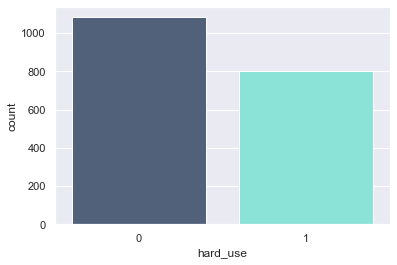

In [94]:
sns.countplot(df_hard1['hard_use'], palette=['#4b5f81',"#7df0e0"]);

In [62]:
X = df_hard1[features]
y = df_hard1['hard_use']

d = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [64]:
my_scorer = make_scorer(f1_score, average='weighted')
c = KFold(3, random_state=42)

In [65]:
# Creating grids for the models
grid_lr = {'C': list(range(1, 100)),
             'penalty':['l1', 'l2'], 
             'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
             }

grid_rf = {'n_estimators' : list(range(1,30)),
             'max_depth': [5, 8, 15, 25, 30],
             'max_features' : ['auto', 'sqrt'],
             'min_samples_split' : [2, 5, 10]}
grid_svm = {'C': [1, 5, 10, 50],
             'kernel': ['linear', 'rbf', 'poly']
             }
grid_xgb = {'max_depth': list(range(1,5)),
             'min_child_weight': list(range(0,15)),
             'subsample': [0.01, 0.1, 0.5, 1]
             }
grid_knn = {'n_neighbors' : list(range(1,50)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,50))
             }

In [66]:
df_hard_result = get_test_results(try_models)
df_hard_result

Runtime: ist 114.3 seconds


,F1_score,Accuracy,Precision,Recall,AUC,Best_Parameter
LogReg,0.8,0.786219,0.817568,0.783172,0.786527,"{'C': 2, 'penalty': 'l1', 'solver': 'saga'}"
RandomForest,0.792013,0.779152,0.815068,0.770227,0.780055,"{'max_depth': 5, 'max_features': 'auto', 'min_..."
SVM,0.80402,0.793286,0.833333,0.776699,0.794964,"{'C': 1, 'kernel': 'rbf'}"
XGBoost,0.81457,0.80212,0.833898,0.796117,0.802728,"{'max_depth': 2, 'min_child_weight': 13, 'subs..."
KNN,0.788396,0.780919,0.833935,0.747573,0.784292,"{'leaf_size': 1, 'n_neighbors': 49, 'weights':..."


In [67]:
df_hard_result.sort_values('F1_score', ascending=False)

,F1_score,Accuracy,Precision,Recall,AUC,Best_Parameter
XGBoost,0.81457,0.80212,0.833898,0.796117,0.802728,"{'max_depth': 2, 'min_child_weight': 13, 'subs..."
SVM,0.80402,0.793286,0.833333,0.776699,0.794964,"{'C': 1, 'kernel': 'rbf'}"
LogReg,0.8,0.786219,0.817568,0.783172,0.786527,"{'C': 2, 'penalty': 'l1', 'solver': 'saga'}"
RandomForest,0.792013,0.779152,0.815068,0.770227,0.780055,"{'max_depth': 5, 'max_features': 'auto', 'min_..."
KNN,0.788396,0.780919,0.833935,0.747573,0.784292,"{'leaf_size': 1, 'n_neighbors': 49, 'weights':..."
